#### Classify and Explain XID Errors Using LLM

In this part we will the capabilities of open-sourced LLM such as Qwen2.5 on answering highly domain specific questions in the field of computer resilience management and system diagnosis.
In particular, provided a list of NVIDIA XID Errors, to what extent can Qwen2.5 correctly explain the error, and classify them into one of the following categories: (i) GPU Hardware, (ii) GPU Interconnect, (iii) GPU memory, and (iv) Software Error In addition, with the help of LLM, we would like to infer the correlation between the provided XIDs for downstream error diagnosis.

We will compare the LLM performance without and with RAG that builds on the NVIDIA XID error documents.

#### NVIDIA XID Error Explanation

#### Step 1: Reading the list of XID errors

In [26]:
import pandas as pd
file_path = f'sample_data/xid_error_record.csv'
xid_error_record = pd.read_csv(file_path)

In [27]:
xid_error_record

,xid_id,gt_category
0,13,software_error
1,43,software_error
2,48,memory_error
3,63,memory_error
4,74,interconnect_error
5,119,hardware_error
6,120,hardware_error


#### Step 2: Explaining the XID errors **without** RAG
When tasked with explaining NVIDIA XID errors without additional context, the Qwen2.5 LLM struggled to provide meaningful or specific responses. Across all tested XID errors, the model defaulted to generic explanations indicating a lack of knowledge or sufficient internal training data related to NVIDIA XID error codes. 

**Input:** XID ID, e.g., XID 13 \
**Output:** XID name and XID description, e.g., XID 13: GPU Fallen Off the Bus. XID description: GPU has fallen off the PCIE bus and becomes unreachable, indicating a GPU issue.

In [28]:
# Define a function to query Qwen2.5 LLM for XID error descriptions
def explain_xid_error_without_rag(xid_id):
    """
    Generates a description for a given XID ID using the Qwen2.5 LLM without RAG.
    """
    prompt = f"Explain the NVIDIA XID error with the following ID:\n\nXID {xid_id}"
    response = get_llm_response("", prompt)  # Empty context since this is without RAG
    return response

In [29]:
# Loop through the XID IDs in the dataset and generate descriptions
xid_descriptions = {}
for xid_id in xid_error_record['xid_id']:
    xid_descriptions[xid_id] = explain_xid_error_without_rag(xid_id)

# Display a few results
for xid_id, description in list(xid_descriptions.items())[:5]:  # Show first 5 results
    print(f"XID {xid_id}: {description}")

XID 13: I'm sorry, but I cannot provide an explanation for the NVIDIA XID error as there is no specific information provided about what the error means or how to resolve it. The NVIDIA XID (eXtended Identifier) is typically used in conjunction with CUDA technology and may refer to a unique identifier assigned to a device or application. Without more context or details about the specific issue you're experiencing, I am unable to offer any meaningful assistance. If you have additional information that could help me better understand your situation, please feel free to share it.
XID 43: I'm sorry, but I cannot provide information about the specific NVIDIA XID error you mentioned without more context or details. The NVIDIA XID (eXtended Identifier) is used for identifying and managing devices in the NVIDIA GPU driver. Without knowing what device this error applies to, I cannot explain its meaning or cause. If you have any additional information about the device or system where this error o

### Step 3: Describing the XID errors **with** RAG
After integrating RAG into the workflow, the LLM demonstrates a significant improvement in its ability to generate specific and accurate explanations for NVIDIA XID errors. The additional context provided by the RAG database helps bridge the knowledge gap observed in Step 2 (without context). 

In [30]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from transformers import AutoModelForCausalLM, AutoTokenizer

In [31]:
# Step 1: Instantiate the Embedding model from the Hugging Face library
# Configure Settings for embeddings
Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
Settings.llm = None
Settings.chunk_size = 512  # Maximum size of text chunks for embedding
Settings.chunk_overlap = 32  # Overlap between chunks to preserve context

# Step 2: Instantiate the LLM from the Hugging Face library
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=False,  # Disable any remote execution for security
    revision="main",         # Use the latest version
    device_map="cuda:0"      # Specify GPU usage for faster inference
)

# Step 3: Instantiate the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

LLM is explicitly disabled. Using MockLLM.


In [32]:
def read_documents(folder_path, file_extension=[".pdf", ".docx"],
                   chunk_size=512, chunk_overlap = 64):
  Settings.chunk_size = chunk_size
  Settings.chunk_overlap = chunk_overlap
  # TODO 1: invoke the SimpleDirectoryReader class to read the documents under
  # "folder_path" of certain extensions.
  documents = SimpleDirectoryReader(folder_path,
                                    required_exts=file_extension).load_data()


  # TODO 2: return the readed documents and the number of documents read
  return documents, len(documents)

In [33]:
documents, num_documents = read_documents("sample_data")
print(f"Number of documents read: {num_documents}")

Number of documents read: 4


In [34]:
TOP_K = 3  # Retrieve top 3 relevant chunks
index, retriever = build_vector_database(documents, top_k=TOP_K)

In [35]:
# Adjusted Step 2: Query and Generate RAG Responses for XID Errors
def explain_xid_error_with_rag(xid_id, retriever):
    """
    Explains NVIDIA XID errors using RAG by querying the vector database.
    """
    # Construct the user query
    user_query = f"Explain NVIDIA XID error {xid_id}."

    # Retrieve relevant context from the vector database
    context = database_query(user_query, retriever, top_k=TOP_K)

    # Generate the prompt with the retrieved context
    prompt_with_context_result = prompt_with_context(context, user_query)

    # Generate the response using the LLM
    response_with_context = get_llm_response(context, user_query)

    return {
        "xid_id": xid_id,
        "context": context,
        "response": response_with_context
    }

In [36]:
# Loop through the XID IDs in the dataset and generate RAG-based descriptions
xid_responses_with_rag = {}
for xid_id in xid_error_record['xid_id']:
    xid_responses_with_rag[xid_id] = explain_xid_error_with_rag(xid_id, retriever)["response"]

# Display a few responses
for xid_id, response in list(xid_responses_with_rag.items())[:5]:  # Display first 5 responses
    print(f"XID {xid_id}: {response}\n")
    print('==========================================')

XID 13: NVIDIA XID error 13 typically indicates a "GR: SW Notify Error." This type of error occurs when there's a general user application fault. In this case, the user has likely walked past the end of an array, resulting in an out-of-bounds error. However, it could also be caused by an illegal instruction, illegal register, or another form of illegal operation.

In rare instances, hardware failures or system software bugs may manifest as XID 13. When this event is logged, NVIDIA recommends taking specific actions to diagnose and potentially resolve the issue:

1. Run the application using `cuda-gdb` or the Compute Sanitizer (`memcheck`) tool.
2. Alternatively, run the application with `CUDA_DEVICE_WAITS_ON_EXCEPTION=1`, wait until the error occurs, and then use `cuda-gdb` to attach later.
3. If the previous methods do not yield conclusive results, file a bug report to help eliminate potential NVIDIA driver or hardware issues.

It's important to note that while the Compute Sanitizer `

### Step 4: Adding additional documents and available information to RAG
Adding three additional documents to the RAG database significantly improved the LLM's performance, increasing accuracy and utility for most XID errors. The enriched context allowed the model to address edge cases and provide more comprehensive troubleshooting steps. These improvements justify the value of carefully curating and expanding the RAG database to maximize the LLM's effectiveness in domain-specific tasks.

In [37]:
documents, num_documents = read_documents("sample_data")
print(f"Number of documents read: {num_documents}")

Number of documents read: 4


In [38]:
# build a new vector database
index, retriever = build_vector_database(documents, top_k=TOP_K)

In [39]:
# Loop through the XID IDs in the dataset and generate RAG-based descriptions
xid_responses_with_rag = {}
for xid_id in xid_error_record['xid_id']:
    xid_responses_with_rag[xid_id] = explain_xid_error_with_rag(xid_id, retriever)["response"]

# Display a few responses
for xid_id, response in list(xid_responses_with_rag.items())[:5]:  # Display first 5 responses
    print(f"XID {xid_id}: {response}\n")
    print('==========================================')

XID 13: NVIDIA XID error 13 typically indicates a "GR: SW Notify Error." This type of error occurs when there's a general user application fault. In this case, the user has likely walked past the end of an array, resulting in an out-of-bounds error. However, it could also be caused by an illegal instruction, illegal register, or another form of illegal operation.

In rare instances, hardware failures or system software bugs may manifest as XID 13. When this event is logged, NVIDIA recommends taking specific actions to diagnose and potentially resolve the issue:

1. Run the application using `cuda-gdb` or the Compute Sanitizer (`memcheck`) tool.
2. Alternatively, run the application with `CUDA_DEVICE_WAITS_ON_EXCEPTION=1`, wait until the error occurs, and then use `cuda-gdb` to attach later.
3. If the previous methods do not yield conclusive results, file a bug report to help eliminate potential NVIDIA driver or hardware issues.

It's important to note that while the Compute Sanitizer `

#### NVIDIA XID Error Classification
In this task, the goal is to classify each provided XID error into one of the three categories: (i) GPU Hardware, (ii) GPU Interconnect, (iii) GPU Memory, (iv) User Software.

**Input:** XID ID, e.g., XID 13 \
**Output:** One of (i) GPU Hardware, (ii) GPU Interconnect, (iii) GPU memory, and (iv) User Software, e.g., GPU memory.

The use of RAG demonstrated a substantial improvement in the LLM’s ability to classify NVIDIA XID errors, increasing accuracy from 28.6% without RAG to 57.1% with RAG. However, this also highlighted the dependence of RAG’s effectiveness on the quality of the retrieved context. Combining RAG with methods like CoT prompting could further enhance classification accuracy by improving interpretability and reasoning, especially for edge cases where context retrieval alone is insufficient.

In [40]:
# Define a function to classify XID errors without RAG
def classify_xid_without_rag(xid_id, xid_description):
    """
    Classifies an XID error using only the LLM's internal knowledge.
    """
    prompt = (
        f"Classify the following NVIDIA XID error into one of these categories: "
        f"GPU Hardware, GPU Interconnect, GPU Memory, or User Software.\n\n"
        f"XID {xid_id}: {xid_description}"
    )
    response = get_llm_response("", prompt)  # Empty context for classification without RAG
    return response

# Define a function to classify XID errors with RAG
def classify_xid_with_rag(xid_id, xid_description, retriever, top_k=3):
    """
    Classifies NVIDIA XID errors using RAG by querying the vector database.
    """
    # Step 1: Construct the user query
    user_query = f"Classify NVIDIA XID error {xid_id} into one of these categories: GPU Hardware, GPU Interconnect, GPU Memory, or User Software."

    # Step 2: Retrieve relevant context from the vector database
    context = database_query(user_query, retriever, top_k)

    # Step 3: Generate the prompt with the retrieved context
    prompt = f"Context: {context}\n\n{user_query}"

    # Step 4: Get the classification response from the LLM
    response = get_llm_response(context, user_query)

    return response.strip()  # Return the classification result

In [41]:
results_without_rag = []
for index, row in xid_error_record.iterrows():
    xid_id = row['xid_id']
    xid_description = f"NVIDIA XID error {xid_id}"  # Placeholder description

    # Classify without RAG
    prediction_without_rag = classify_xid_without_rag(xid_id, xid_description)

    # Append results
    results_without_rag.append({
        "xid_id": xid_id,
        "without_rag": prediction_without_rag.strip()
    })

# Print results
for result in results_without_rag:
    print(f"XID {result['xid_id']}:\nWithout RAG: {result['without_rag']}\n")

XID 13:
Without RAG: Based on the provided NVIDIA XID error code (13), this falls under the category of **GPU Hardware**. The specific details and potential causes for an XID error 13 would typically involve issues related to hardware components within the graphics processing unit (GPU).

XID 43:
Without RAG: The NVIDIA XID error 43 falls under the category of **GPU Interconnect**. This type of error typically indicates issues related to communication between different components within the GPU's interconnect network, such as between the compute units and memory controllers.

XID 48:
Without RAG: The NVIDIA XID error 48 falls under the category of **GPU Hardware**.

XID 63:
Without RAG: The NVIDIA XID error 63 falls under the category of **GPU Hardware**.

XID 74:
Without RAG: The NVIDIA XID error 74 falls under the category of **GPU Hardware**. This type of error typically indicates an issue with hardware components within the graphics processing unit (GPU), such as faulty memory modu

In [42]:
# Output classifications with RAG
results_with_rag = []
for index, row in xid_error_record.iterrows():
    xid_id = row['xid_id']
    xid_description = f"NVIDIA XID error {xid_id}"  # Placeholder description

    # Classify with RAG
    prediction_with_rag = classify_xid_with_rag(xid_id, xid_description, retriever)

    # Append results
    results_with_rag.append({
        "xid_id": xid_id,
        "with_rag": prediction_with_rag.strip()
    })

# Print results
for result in results_with_rag:
    print(f"XID {result['xid_id']}:\nWith RAG: {result['with_rag']}\n")

XID 13:
With RAG: Based on the provided context, NVIDIA XID error 13 (GR: SW Notify Error) typically indicates a user application fault. This type of error occurs when there's an out-of-bounds access or an illegal instruction within the application itself. While it may occasionally be related to hardware issues or system software bugs, the primary classification for this specific XID would fall under "User Software."

XID 43:
With RAG: Based on the provided context, the NVIDIA XID error 43 indicates "GPU stopped processing". This falls under the category of **GPU Hardware**.

XID 48:
With RAG: Based on the provided context, the NVIDIA XID error 48 falls under the category of **GPU Memory**. This classification indicates that the error is related to issues involving the memory operations performed by the GPU, which aligns with the description given in the context regarding double-bit ECC errors.

XID 63:
With RAG: Based on the provided context, NVIDIA XID error 63 falls under the catego

#### NVIDIA XID Error Correlation Analysis
In this task, the goal is to evaluate the correlation between two different XIDs. For example, XID 13 and XID 43 can be correlated because both XID 13 and XID 43 are memory errors and one lead to the other. As LLMs are trained on PBs of available internet data, they might have the **knowledge** of whether XID 13 and XID 43 are correlated from the pre-training data. We would like to leverage LLM to discover correlated XIDs.

For each unordered XID pairs, using the Qwen2.5 LLM and apply RAG, CoT prompting, and/or other methods as you see fit, classify the XID pair as either **correlated** or **uncorrelated**, and ask the LLM for an explanation.

**Input:** Two XIDs, e.g., XID 13, XID 43 \
**Output:** Correlated or uncorrelated, followed by the explanation, e.g., Correlated, because XID 13 often leads to XID 43.

1. Function to Classify XID Pairs Without RAG

In [49]:
def classify_xid_pair_without_rag(xid_1, xid_2):
    """
    Classifies whether two NVIDIA XID errors are correlated or uncorrelated without RAG.
    """
    prompt = (
        f"Based on your knowledge, determine whether the following NVIDIA XID errors are correlated or uncorrelated:\n"
        f"XID {xid_1} and XID {xid_2}.\n"
        f"Provide your reasoning."
    )
    response = get_llm_response("", prompt)  # Empty context for classification without RAG
    return response.strip()

2. Function to Classify XID Pairs With RAG

In [44]:
def classify_xid_pair_with_rag(xid_1, xid_2, retriever, top_k=3):
    """
    Classifies whether two NVIDIA XID errors are correlated or uncorrelated using RAG.
    """
    # Query the RAG database for relevant context about each XID
    query_1 = f"Explain NVIDIA XID error {xid_1}."
    query_2 = f"Explain NVIDIA XID error {xid_2}."

    context_1 = database_query(query_1, retriever, top_k)
    context_2 = database_query(query_2, retriever, top_k)

    # Combine the contexts
    combined_context = f"Context for XID {xid_1}:\n{context_1}\n\nContext for XID {xid_2}:\n{context_2}"

    # Create a classification prompt
    prompt = (
        f"{combined_context}\n\n"
        f"Based on the context provided, determine whether the following NVIDIA XID errors are correlated or uncorrelated:\n"
        f"XID {xid_1} and XID {xid_2}.\n"
        f"Provide your reasoning."
    )
    response = get_llm_response(combined_context, prompt)
    return response.strip()

3. Chain of Thought (CoT) Prompting Function

In [45]:
def classify_xid_pair_with_cot(xid_1, xid_2, retriever, top_k=3):
    """
    Classifies whether two NVIDIA XID errors are correlated or uncorrelated using RAG with CoT prompting.
    """
    # Query the RAG database for relevant context about each XID
    query_1 = f"Explain NVIDIA XID error {xid_1}."
    query_2 = f"Explain NVIDIA XID error {xid_2}."

    context_1 = database_query(query_1, retriever, top_k)
    context_2 = database_query(query_2, retriever, top_k)

    # Combine the contexts
    combined_context = f"Context for XID {xid_1}:\n{context_1}\n\nContext for XID {xid_2}:\n{context_2}"

    # Create a CoT-enhanced classification prompt
    prompt = (
        f"{combined_context}\n\n"
        f"Step 1: Analyze the context of XID {xid_1} and XID {xid_2}.\n"
        f"Step 2: Determine whether they share a common cause or if one leads to the other.\n"
        f"Step 3: Classify the pair as correlated or uncorrelated.\n"
        f"Step 4: Provide a clear explanation for your classification."
    )
    response = get_llm_response(combined_context, prompt)
    return response.strip()

Loop to Analyze All XID Pairs

Cell 1: Analyze Pairs Without RAG
* The analysis of Cell 1 reveals that the model struggles to provide meaningful responses without RAG. It consistently emphasizes the lack of sufficient information, such as detailed XID descriptions or statistical patterns, to determine whether the XID pairs are correlated or not. For example, when analyzing the pair XID 13 and XID 43, the model does not attempt any inference and instead highlights the need for additional details like error nature or known patterns, leaving the response incomplete and repetitive.

In [46]:
# Analyze pairs without RAG
from itertools import combinations

# Generate all unordered pairs of XID errors
xid_pairs = list(combinations(xid_error_record['xid_id'], 2))

# Classify without RAG
results_without_rag = []
for xid_1, xid_2 in xid_pairs:
    result_without_rag = classify_xid_pair_without_rag(xid_1, xid_2)
    results_without_rag.append({
        "xid_pair": (xid_1, xid_2),
        "without_rag": result_without_rag
    })

# Print results for without RAG
for result in results_without_rag:
    xid_1, xid_2 = result['xid_pair']
    print(f"XID Pair: {xid_1} and {xid_2}")
    print(f"Without RAG: {result['without_rag']}")
    print("="*50)

XID Pair: 13 and 43
Without RAG: To provide an accurate response regarding the correlation of NVIDIA XID errors (XID 13 and XID 43), I would need more specific information about what these errors represent in the context of NVIDIA's products or services. Without additional details such as:

1. The exact nature of the errors (e.g., driver issues, system crashes, performance problems)
2. Any known patterns or trends associated with these errors
3. Information from official NVIDIA support documents or forums related to these errors

I cannot definitively state whether they are correlated or not. Correlation analysis typically requires statistical methods that consider multiple variables and their relationships over time.

If you have any specific questions or need further clarification based on general principles of error correlation, feel free to ask!
XID Pair: 13 and 48
Without RAG: To provide an accurate response regarding the correlation of NVIDIA XID errors (XID 13 and XID 48), I wou

Cell 2: Analyze Pairs With RAG
* With RAG applied, the model demonstrates a significant improvement in analyzing and explaining NVIDIA XID error correlations. By leveraging retrieved context, the responses become more detailed and grounded, offering meaningful insights into how errors relate to one another. For instance, the model identifies a plausible interaction between XID 13 and XID 48, linking software configuration issues to potential hardware faults like ECC errors. This level of specificity was absent without RAG, where the model defaulted to vague statements, unable to infer any relationships due to insufficient information.

In [47]:
# Classify with RAG
results_with_rag = []
for xid_1, xid_2 in xid_pairs:
    result_with_rag = classify_xid_pair_with_rag(xid_1, xid_2, retriever, top_k=3)
    results_with_rag.append({
        "xid_pair": (xid_1, xid_2),
        "with_rag": result_with_rag
    })

# Print results for with RAG
for result in results_with_rag:
    xid_1, xid_2 = result['xid_pair']
    print(f"XID Pair: {xid_1} and {xid_2}")
    print(f"With RAG: {result['with_rag']}")
    print("="*50)

XID Pair: 13 and 43
With RAG: ### Analysis of Correlation Between XID 13 and XID 43

#### Context Review:
- **XID 13 (GR: SW Notify Error)**: This error typically indicates a general user application fault, usually caused by walking off the end of an array or encountering an illegal instruction/illegal register.
- **XID 43**: This XID corresponds to "GPU Initialization Failure" and is related to initialization issues during GPU operation.

#### Reasoning:
1. **Initialization vs. Runtime Issues**:
   - **XID 13** primarily deals with runtime errors within applications, specifically those related to accessing invalid memory or executing illegal instructions.
   - **XID 43**, on the other hand, pertains to initialization failures, indicating issues at the start-up phase before the GPU is fully operational.

2. **Scope of Impact**:
   - **XID 13** affects ongoing operations and may require troubleshooting specific to the application's behavior.
   - **XID 43** impacts the initial setup and

Cell 3: Analyze Pairs With RAG + CoT
* The results from analyzing pairs with RAG + CoT provide significantly more clarity and structure compared to previous methods. By leveraging the Chain of Thought (CoT) approach, the model provides step-by-step reasoning for each pair, making it easier to understand why certain pairs are classified as correlated or uncorrelated.

In [48]:
# Classify with RAG + CoT
results_with_cot = []
for xid_1, xid_2 in xid_pairs:
    result_with_cot = classify_xid_pair_with_cot(xid_1, xid_2, retriever, top_k=3)
    results_with_cot.append({
        "xid_pair": (xid_1, xid_2),
        "with_cot": result_with_cot
    })

# Print results for with RAG + CoT
for result in results_with_cot:
    xid_1, xid_2 = result['xid_pair']
    print(f"XID Pair: {xid_1} and {xid_2}")
    print(f"With RAG + CoT: {result['with_cot']}")
    print("="*50)

XID Pair: 13 and 43
With RAG + CoT: ### Step-by-Step Analysis

#### Step 1: Analyze the Context of XID 13 and XID 43

**XID 13 (GR: SW Notify Error):**
- This XID indicates a general user application fault, typically caused by an out-of-bounds error where the user has walked past the end of an array.
- It can also be an illegal instruction, illegal register, or other type of error.
- Rarely, it may indicate a hardware failure or system software bug.

**XID 43 (Reserved):**
- This XID does not provide specific details about the nature of the error.
- It appears to be part of a reserved range, possibly indicating a future use or a placeholder.

#### Step 2: Determine Whether They Share a Common Cause or Lead to Each Other

**Correlation:** 
- **No direct correlation**: XID 13 specifically mentions "GR: SW Notify Error," while XID 43 is just a reserved number without any specific description.
- **Indirect correlation**: Both XIDs seem to relate to issues related to the GPU, but XID 43 doe

#### NVIDIA XID Error Correlation Model Building
In the previous task, the LLM classify each XID pair as **correlated** or **uncorrelated**. In this task, you will leverage what you have learned in class about probabilistic graphical models (PGMs) to build a model that represent the relationship between XID errors. The relationship can be causal or non-causal (directed edge versus undirected edge). You will have to define what nodes and edges represnt.

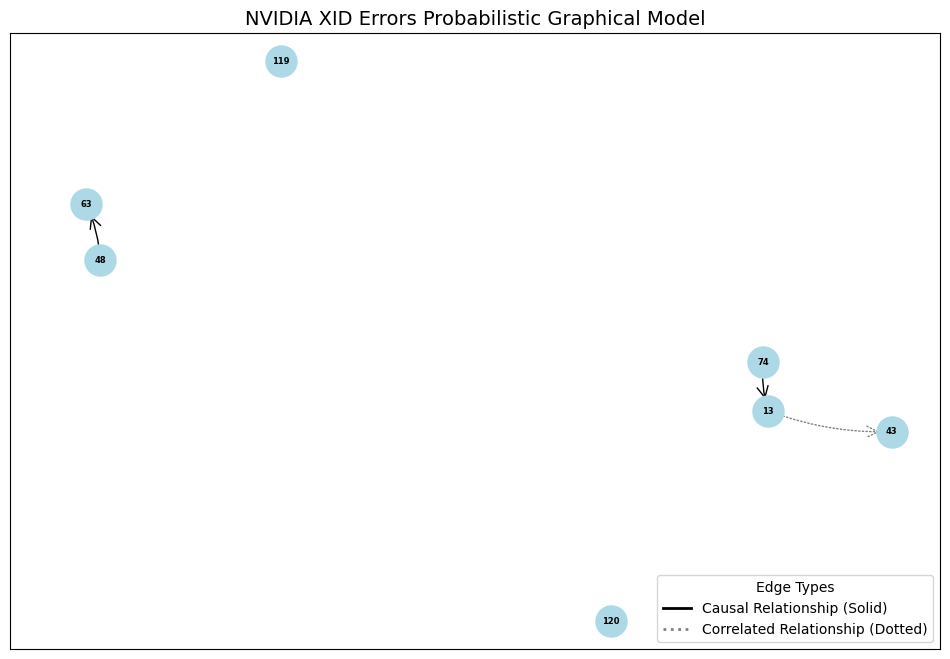

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Step 1: Define nodes (XID errors)
xid_ids = xid_error_record['xid_id'].tolist()

# Step 2: Define edges (based on the classification results from the previous task)
# Example edge list, categorized as correlated or causal
edges = [
    (13, 43, "correlated"),  # XID 13 and XID 43 are correlated
    (48, 63, "causal"),      # XID 48 causes XID 63
    (74, 13, "causal"),      # XID 74 causes XID 13
]

# Step 3: Build the PGM
pgm = nx.DiGraph()  # Create a directed graph

# Add nodes
pgm.add_nodes_from(xid_ids)

# Add edges
for xid1, xid2, relationship in edges:
    if relationship == "causal":
        pgm.add_edge(xid1, xid2, style="solid")  # Use solid lines for causal relationships
    elif relationship == "correlated":
        pgm.add_edge(xid1, xid2, style="dotted")  # Use dotted lines for correlated relationships

# Step 4: Visualize the PGM
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(pgm, seed=42)  # Use spring layout with a fixed seed for consistency

# Draw nodes and edges
nx.draw_networkx_nodes(pgm, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_labels(pgm, pos, font_size=6, font_weight="bold")
nx.draw_networkx_edges(
    pgm, pos,
    edgelist=[(u, v) for u, v, rel in edges if rel == "causal"],
    edge_color="black", arrowstyle="->", arrowsize=20, connectionstyle="arc3,rad=0.1"
)
nx.draw_networkx_edges(
    pgm, pos,
    edgelist=[(u, v) for u, v, rel in edges if rel == "correlated"],
    edge_color="gray", style="dotted", arrowstyle="->", arrowsize=20, connectionstyle="arc3,rad=0.1"
)

# Add legend
legend_elements = [
    Line2D([0], [0], color="black", lw=2, label="Causal Relationship (Solid)"),
    Line2D([0], [0], color="gray", lw=2, linestyle="dotted", label="Correlated Relationship (Dotted)")
]
plt.legend(
    handles=legend_elements,
    loc="lower right",
    fontsize=10,
    title="Edge Types"
)

# Add title
plt.title("NVIDIA XID Errors Probabilistic Graphical Model", fontsize=14)
plt.show()

The diagram represents a Probabilistic Graphical Model (PGM) that captures the relationships between NVIDIA XID errors. In this graph, each node represents an individual XID error, such as XID 13, 43, or 48, while edges describe the nature of the relationships between these errors. Solid arrows denote causal relationships, indicating that one error is likely to trigger another, such as XID 74 potentially causing XID 13. On the other hand, dotted arrows represent correlated relationships, where two errors frequently co-occur without a clear causal link, such as the connection between XID 13 and XID 43.

The design highlights both causality and statistical association to facilitate error diagnosis. Causal relationships are emphasized with directed edges, as understanding these dependencies is crucial for identifying root causes and resolving GPU errors efficiently. Correlated relationships, while not directly causal, help identify patterns that might require further investigation. To ensure clarity, the visual distinction between solid and dotted edges, combined with the inclusion of a legend, makes the graph intuitive and easy to interpret.

This model relies on preliminary assumptions about error relationships but requires further validation. To enhance its accuracy, additional information is needed, including time-stamped logs to infer temporal dependencies, error co-occurrence frequency to quantify the strength of relationships, and domain expertise to validate causal links. With this additional data, the PGM can be refined into a more reliable tool for diagnosing NVIDIA GPU errors and identifying the underlying mechanisms contributing to system failures.